## Further text preprocessing

### Objectives of this test

- Implement Latent Dirichlet Allocation (**LDA**) from **Gensim** package along with the Mallet’s implementation (via Gensim). 

- Implement **Mallet** that optimizes LDA. Mallet is known to run faster and gives better topic segregation.

- Also extract the volume and percentage contribution of each topic to get **an idea of how important a topic is**.

### Pre-requisites: Downloading NLTK Dutch stopwords, data handling tools, model preprocessing & plotting tools, and SpaCy model

In [24]:
# NLTK
import nltk
nltk.download('stopwords', 'dutch')

[nltk_data] Downloading package stopwords to dutch...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
# Python data analysis tools and python module for printing
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [26]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [27]:
# SpaCy for lemmatization
import spacy

In [28]:
# Plotting tools
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Preparing stopwords

In [30]:
# NLTK Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = nltk.corpus.stopwords.words('dutch')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tokenizing words and cleaning-up text of one Dutch legal text file

In [31]:
# Importing file handling library
import os

data = []
path = 'drive/MyDrive/numac=2019041722.txt'
with open(path, 'r') as file:
        data.append(file.read())

In [32]:
# Tokenizing each sentence into a list of words, removing punctuations and unnecessary characters altogether.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words)

[['verslag', 'aan', 'de', 'koning', 'sire', 'het', 'ontwerp', 'van', 'koninklijk', 'besluit', 'dat', 'wij', 'de', 'eer', 'hebben', 'aan', 'uwe', 'majesteit', 'voor', 'te', 'leggen', 'beoogt', 'de', 'uitvoering', 'van', 'de', 'artikelen', 'ter', 'tot', 'quinquies', 'van', 'het', 'wetboek', 'van', 'de', 'belasting', 'over', 'de', 'toegevoegde', 'waarde', 'hierna', 'wbtw', 'de', 'artikelen', 'bis', 'tot', 'van', 'het', 'wetboek', 'van', 'de', 'hierna', 'wib', 'de', 'artikelen', 'tot', 'en', 'tot', 'en', 'van', 'het', 'wetboek', 'van', 'de', 'minnelijke', 'en', 'gedwongen', 'invordering', 'van', 'fiscale', 'en', 'niet', 'fiscale', 'hierna', 'en', 'de', 'artikelen', 'tot', 'en', 'van', 'de', 'programmawet', 'van', 'maart', 'hierna', 'programmawet', 'zoals', 'gewijzigd', 'door', 'de', 'wet', 'van', 'februari', 'houdende', 'fiscale', 'fraude', 'bestrijdende', 'financiele', 'alsook', 'diverse', 'bepalingen', 'en', 'de', 'wet', 'van', 'april', 'houdende', 'wijzigingen', 'van', 'het', 'wetboek',

### Creating bigrams and trigrams

In [33]:
# Building the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


###  Removing stopwords, making bigrams & trigtrams, and lemmatizing

In [34]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### Initializing SpaCy's Dutch NLP model (large size)

In [35]:
 !pip install -U spacy
 !python -m spacy download nl_core_news_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 568.1 MB 8.5 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_lg')


### Calling the functions in order

In [36]:
 # Removing Stop Words
data_words_nostops = remove_stopwords(data_words)

# Forming Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Loading the SpaCy 'nl' model, keeping only tagger component (for efficiency)
nlp = spacy.load('nl_core_news_lg', disable=['parser', 'ner'])

# Doing lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized)

[['verslag', 'koning', 'sire', 'ontwerp', 'koninklijk', 'besluiten', 'eer', 'majesteit', 'leggen', 'beogen', 'uitvoering', 'artikel', 'quinquie', 'wetboek', 'belasting', 'toegevoegde', 'waarde', 'hierna', 'wbtw', 'artikel', 'wetboek', 'hierna', 'artikel', 'wetboek', 'minnelijk', 'dwingen', 'invordering', 'fiscaal', 'fiscaal', 'hierna', 'artikel', 'programma_wet', 'hierna', 'programma_wet', 'wijzigen', 'wet', 'houdende', 'fiscaal', 'fraude', 'bestrijden', 'financieel', 'divers', 'bepaling', 'wet', 'houd_en', 'wijziging', 'wetboek', 'belasting', 'toegevoegde', 'waarde', 'wetboek', 'wetboek', 'minnelijk', 'dwingen', 'invordering', 'fiscaal', 'fiscaal', 'programma_wet', 'verwerking', 'notariaat', 'nieuw', 'werkwijze', 'kaderen', 'modernisering', 'federaal', 'overheid_dienst', 'administratief', 'vereenvoudiging', 'kostenbesparing', 'hoof_ddoel', 'in_stellen', 'ontvangers', 'toe_laten', 'kennisgeving', 'elektronisch', 'verzenden', 'kennisgeving', 'bestemmen', 'notaris', 'persoon', 'bevoegd',

**NOTE**: The empty lists (within this extensive python list of individual Dutch words) are stripped off of words that are negligible (e.g. stopwords) and words that have to be retained (e.g. names of persons; complete article code numbers; etc.). **FINER PREPROCESSING VIA NER can be implemented in this part**. 

### Creating the Dictionary and Corpus needed for Topic Modeling

In [37]:
# Creating Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Creating Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Viewing corpus
print(corpus)

[[(0, 2), (1, 6), (2, 1), (3, 2), (4, 1), (5, 1), (6, 6), (7, 1), (8, 1), (9, 2), (10, 1), (11, 3), (12, 4), (13, 1), (14, 4), (15, 2), (16, 2), (17, 3), (18, 6), (19, 2), (20, 10), (21, 1), (22, 8), (23, 99), (24, 1), (25, 7), (26, 1), (27, 1), (28, 4), (29, 25), (30, 4), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 12), (40, 1), (41, 5), (42, 10), (43, 26), (44, 1), (45, 1), (46, 1), (47, 54), (48, 7), (49, 2), (50, 2), (51, 2), (52, 1), (53, 2), (54, 6), (55, 1), (56, 9), (57, 1), (58, 2), (59, 10), (60, 4), (61, 11), (62, 2), (63, 1), (64, 3), (65, 5), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 6), (79, 2), (80, 3), (81, 1), (82, 2), (83, 6), (84, 3), (85, 1), (86, 2), (87, 1), (88, 2), (89, 6), (90, 26), (91, 1), (92, 1), (93, 6), (94, 1), (95, 2), (96, 1), (97, 1), (98, 5), (99, 8), (100, 2), (101, 1), (102, 15), (103, 1), (104, 3), (105, 2), (106, 1), (107, 1), (108, 4), (109, 2

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, **word id 0 occurs once** in the document. Likewise, **word id 1 occurs once too**, and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary. (From https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)

In [38]:
# Passing the id as a key to the dictionary to see what word a given ID corresponds to
id2word[0]

'Europees'

In [39]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]

[[('Europees', 2),
  ('Wbtw', 6),
  ('aan_duiden', 1),
  ('aanduiding', 2),
  ('aangeduid', 1),
  ('aangepaste', 1),
  ('aangetekend', 6),
  ('aanleiding', 1),
  ('aanvrager', 1),
  ('aanwending', 2),
  ('administrateur', 1),
  ('administratie', 3),
  ('administratief', 4),
  ('adresseren', 1),
  ('advies', 4),
  ('af_leveren', 2),
  ('afgeleverd', 2),
  ('akt', 3),
  ('akte', 6),
  ('algemeen', 2),
  ('ambtenaar', 10),
  ('anderzijds', 1),
  ('art', 8),
  ('artikel', 99),
  ('associeren', 1),
  ('attest', 7),
  ('authenticiteit', 1),
  ('authentiek', 1),
  ('bedoeld', 4),
  ('bedoelen', 25),
  ('beeld', 4),
  ('begroting', 1),
  ('begunstigen', 1),
  ('beheerssysteem', 1),
  ('behoren', 2),
  ('bekleed', 1),
  ('bekleeden', 1),
  ('belast', 1),
  ('belasten', 1),
  ('belasting', 12),
  ('beogen', 1),
  ('bepalen', 5),
  ('bepaling', 10),
  ('bericht', 26),
  ('beschermen', 1),
  ('beschikbaar', 1),
  ('beschikken', 1),
  ('besluit', 54),
  ('besluiten', 7),
  ('bestemmen', 2),
  ('bes

### Building the topic model

In [40]:
# Building LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

###  Viewing the topics in LDA model

You can see the keywords for each topic and the weightag (importance) of each keyword using lda_model.print_topics() as shown next.

In [41]:
# Printing keywords for 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.003*"artikel" + 0.003*"één" + 0.003*"besluit" + 0.003*"wet" + 0.003*"lid" '
  '+ 0.003*"wetboek" + 0.003*"elektronisch" + 0.003*"bedoelen" + '
  '0.003*"bericht" + 0.003*"koninklijk"'),
 (1,
  '0.004*"artikel" + 0.004*"wet" + 0.004*"één" + 0.004*"lid" + 0.003*"besluit" '
  '+ 0.003*"wetboek" + 0.003*"koninklijk" + 0.003*"programma_wet" + '
  '0.003*"bericht" + 0.003*"bedoelen"'),
 (2,
  '0.004*"besluit" + 0.004*"wet" + 0.004*"artikel" + 0.004*"lid" + 0.003*"één" '
  '+ 0.003*"programma_wet" + 0.003*"bedoelen" + 0.003*"wetboek" + '
  '0.003*"koninklijk" + 0.003*"elektronisch"'),
 (3,
  '0.003*"artikel" + 0.003*"wet" + 0.003*"één" + 0.003*"lid" + 0.003*"besluit" '
  '+ 0.003*"koninklijk" + 0.003*"elektronisch" + 0.003*"op_heffen" + '
  '0.003*"bericht" + 0.003*"wetboek"'),
 (4,
  '0.004*"artikel" + 0.003*"besluit" + 0.003*"wet" + 0.003*"één" + 0.003*"lid" '
  '+ 0.003*"bericht" + 0.003*"wetboek" + 0.003*"elektronisch" + '
  '0.003*"programma_wet" + 0.003*"bedoelen"'),
 (5,
  '0

**NOTE**: 

The weights reflect how important a keyword is to that topic.

Looking at these keywords, you can guess what this topic could be.

### Compute Model Perplexity and Coherence Score

In [42]:
# Computing Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Computing Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.5816528960112155

Coherence Score:  0.31134612637837206


### Visualizing topic-keywords distribution

In [43]:
# Feeding the model into the pyLDAvis instance
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x             y  topics  cluster       Freq
topic                                                    
13    -0.141857  2.725116e-08       1        1  99.970699
11    -0.013109 -4.405358e-05       2        1   0.001551
18    -0.007218  8.042164e-05       3        1   0.001550
9      0.000055 -7.348268e-06       4        1   0.001548
10     0.000732 -4.203234e-05       5        1   0.001548
5      0.001438  1.932960e-05       6        1   0.001548
8      0.004070 -3.178663e-05       7        1   0.001547
7      0.004304  4.912675e-05       8        1   0.001547
14     0.005562  2.829801e-05       9        1   0.001547
19     0.005626 -2.558690e-06      10        1   0.001547
6      0.008136  9.060985e-06      11        1   0.001546
16     0.008196 -8.855873e-05      12        1   0.001546
2      0.009852  5.356876e-05      13        1   0.001545
1      0.011753 -3.190198e-05      14        1   0.001544
4      0.013917 -3.371414e-05      15        1   0.001542
17     0.017050  2.581924e-06      16        1   0.001535
0      0.017725  4.001402e-06      17        1   0.001531
15     0.017745  7.966318e-06      18        1   0.001531
3      0.017780  1.206969e-05      19        1   0.001530
12     0.018240  1.550203e-05      20        1   0.001517, topic_info=            Term       Freq      Total Category  logprob  loglift
23       artikel  97.000000  97.000000  Default  30.0000  30.0000
315          wet  64.000000  64.000000  Default  29.0000  29.0000
47       besluit  53.000000  53.000000  Default  28.0000  28.0000
330          één  45.000000  45.000000  Default  27.0000  27.0000
173          lid  44.000000  44.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
320     wijzigen   0.000068  13.896130  Topic20  -5.8018  -1.1377
61           bis   0.000068  10.924804  Topic20  -5.8018  -0.8971
152  invordering   0.000068   8.949913  Topic20  -5.8018  -0.6978
224     quinquie   0.000068  10.928490  Topic20  -5.8019  -0.8975
102      fiscaal   0.000068  14.884362  Topic20  -5.8019  -1.2064

[1368 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2         1  0.961977   aan_duiden
4         1  0.962140    aangeduid
5         1  0.961637   aangepaste
6         1  1.003173  aangetekend
7         1  0.961631   aanleiding
...     ...       ...          ...
322       1  0.962305        woord
323       1  1.005023     zakelijk
327       1  1.005820         zien
329       1  0.962148       zorgen
330       1  1.010312          één

[203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 12, 19, 10, 11, 6, 9, 8, 15, 20, 7, 17, 3, 2, 5, 18, 1, 16, 4, 13])

**How to make inferences from pyLDAvis' output:**

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

## Mallet's version of LDA

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. 

In [23]:
# Upgrading Gensim
# Updated to enforce Gensim v3.8 in Colab (the last version to support running topic models via Mallet).
# https://github.com/polsci/colab-gensim-mallet
!pip install --upgrade gensim==3.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.2 MB 2.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [44]:
# Installing Mallet
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2022-06-12 12:52:30--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-06-12 12:52:30--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  44.4MB/s    in 0.3s    

2022-06-12 12:52:31 (44.4 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [45]:
mallet_path = 'mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [46]:
# Showing Topics
pprint(ldamallet.show_topics(formatted=False))

[(9,
  [('goed', 0.23076923076923078),
   ('besluiten', 0.1794871794871795),
   ('betrekking', 0.1282051282051282),
   ('toepassing', 0.10256410256410256),
   ('verankering', 0.05128205128205128),
   ('uniek', 0.05128205128205128),
   ('Europees', 0.05128205128205128),
   ('bijlag', 0.02564102564102564),
   ('impactanalyse', 0.02564102564102564),
   ('groet', 0.02564102564102564)]),
 (10,
  [('technisch', 0.2916666666666667),
   ('modelbericht', 0.125),
   ('bedoelen', 0.08333333333333333),
   ('doen', 0.08333333333333333),
   ('bepalen', 0.08333333333333333),
   ('certificeren', 0.041666666666666664),
   ('fod', 0.041666666666666664),
   ('naam', 0.041666666666666664),
   ('daarnaast', 0.041666666666666664),
   ('kanselarij', 0.041666666666666664)]),
 (2,
  [('besluit', 0.2153846153846154),
   ('bis', 0.16923076923076924),
   ('wbtw', 0.15384615384615385),
   ('art', 0.12307692307692308),
   ('houden', 0.09230769230769231),
   ('federaal', 0.06153846153846154),
   ('in_voegen', 0.0461

In [47]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4273505532060036


**NOTE:** A *slight increase* in **coherence score** from  **0.31134612637837206** to **0.4273505532060036**.

### Finding the optimal number of topics for LDA

The approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

In [48]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [49]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

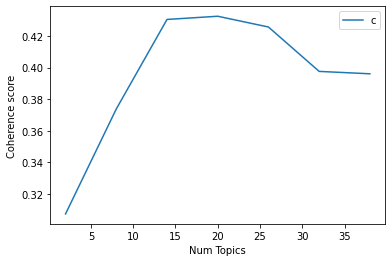

In [50]:
# Showing graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

**NOTE:**
The optimal **coherence score** shown in this plot lies at **20 number of topics**.

In [51]:
# Printing the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3073
Num Topics = 8  has Coherence Value of 0.3738
Num Topics = 14  has Coherence Value of 0.4305
Num Topics = 20  has Coherence Value of 0.4325
Num Topics = 26  has Coherence Value of 0.4257
Num Topics = 32  has Coherence Value of 0.3976
Num Topics = 38  has Coherence Value of 0.3961


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out.

### Choosing the model with twenty (20) topics

In [52]:
# Select the model and print the topics
# The best LDA model with the optimal coherence score has 20 topics, which is
# index 3 from the model_list list
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.186*"vervangen" + 0.171*"waarde" + 0.129*"lid" + 0.086*"minnelijk" + '
  '0.071*"notaris" + 0.057*"tabel" + 0.057*"beeld" + 0.043*"administratie" + '
  '0.043*"verplichting" + 0.029*"ministerieel"'),
 (1,
  '0.211*"ingevoegd" + 0.158*"bericht" + 0.105*"erflater" + '
  '0.053*"impactanalyse" + 0.053*"betrekking" + 0.053*"in_voeren" + '
  '0.053*"model" + 0.053*"beschikbaar" + 0.053*"erfop_volging" + '
  '0.053*"verstuurd"'),
 (2,
  '0.482*"besluit" + 0.116*"ministerieel" + 0.062*"zakelijk" + '
  '0.054*"op_nemen" + 0.054*"twee" + 0.045*"bepalen" + 0.036*"bijzonder" + '
  '0.018*"waartoe" + 0.018*"digitaal" + 0.009*"voornoemd"'),
 (3,
  '0.277*"elektronisch" + 0.149*"wib" + 0.096*"bevoegd" + 0.085*"art" + '
  '0.064*"mee_delen" + 0.064*"inlichting" + 0.032*"goed" + 0.032*"storing" + '
  '0.021*"bijlag" + 0.021*"zes"'),
 (4,
  '0.228*"koninklijk" + 0.193*"wbtw" + 0.158*"leten" + 0.053*"bericht" + '
  '0.053*"specificeren" + 0.035*"aanduiding" + 0.035*"kader" + 0.035*"hierna" '
 

### Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the **topic number that has the highest percentage contribution** in that document.

In [53]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data_words)

In [54]:
# Formatting
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Showing
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.1023,"één, minister, fiscaal, kennisgeving, wijzigen...","[verslag, aan, de, koning, sire, het, ontwerp,..."


## CONCLUSION

From one (1) Dutch legal text file that was cleaned, further ML preprocessing and unsupervised topic extraction were carried out via:

- A basic topic model using Gensim’s LDA;

- pyLDAvis for topic visualisation; and

- Mallet’s LDA implementation.